# Digital Elevation Model of the Marche Region
In this notebook we plot the DEM of Marche, a region of Central Italy. We use the the [Tinitaly](http://tinitaly.pi.ingv.it/) DEM from INGV and the [Copernicus Global Digital Elevation Models](https://portal.opentopography.org/raster?opentopoID=OTSDEM.032021.4326.3) at 30 meter resolution.

In [1]:
import os
import numpy as np
from osgeo import gdal, osr, ogr
import skimage
from skimage import io
from skimage import util
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
print("numpy version: %s"%np.__version__)
print("GDAL version: %s"%gdal.__version__)

numpy version: 1.25.2
GDAL version: 3.7.2


## Tinitaly DEM

2


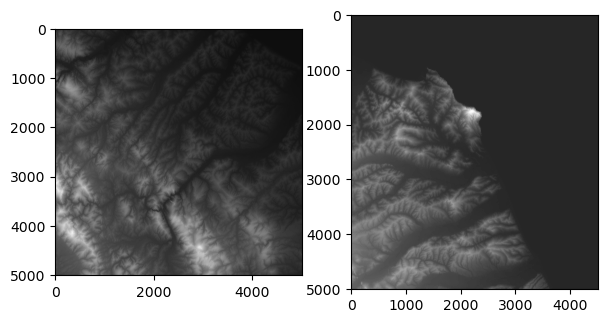

In [2]:
path = 'data/raster/italy/dem/tinitaly/'
dem1_path = path + 'smooth_w48080_s10.tif'
dem2_path = path + 'smooth_w48085_s10.tif'
img1 = io.imread(dem1_path)
img2 = io.imread(dem2_path)
print(img1.ndim)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 7))
axes[0].imshow(img1, cmap='gray')
axes[1].imshow(img2, cmap='gray')

We will use the values in the 2D array as a function of the coordinates z = f(x, y)

In [4]:
print(gdal.Info(dem1_path))

Driver: GTiff/GeoTIFF
Files: data/raster/italy/dem/tinitaly/smooth_w48080_s10.tif
Size is 5010, 5010
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 32N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 32N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",9,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1],
      

In [5]:
ds1 = gdal.Open(dem1_path, gdal.GA_ReadOnly)
band1 = ds1.GetRasterBand(1)
z1 = band1.ReadAsArray()
print("Band Type={}".format(gdal.GetDataTypeName(band1.DataType)))
band1.XSize, band1.YSize, band1.DataType, ds1.GetProjection()

Band Type=Int32


(5010,
 5010,
 5,
 'PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32632"]]')

In [6]:
ds2 = gdal.Open(dem2_path, gdal.GA_ReadOnly)
band2 = ds2.GetRasterBand(1)
z2 = band2.ReadAsArray()
print("Band Type={}".format(gdal.GetDataTypeName(band2.DataType)))
band2.XSize, band2.YSize, band2.DataType, ds2.GetProjection()

Band Type=Int32


(4505,
 5010,
 5,
 'PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32632"]]')

In [7]:
x_origin, x_pixel_resolution, row_rotation, y_origin, column_rotation, y_pixel_resolution = ds1.GetGeoTransform()
print('x_origin: {}, y_origin: {}, pixel resolution: {}'.format(x_origin, y_origin, x_pixel_resolution))

x_origin: 799950.0, y_origin: 4850050.0, pixel resolution: 10.0


In [8]:
min = band1.GetMinimum()
max = band1.GetMaximum()
if not min or not max:
    (min,max) = band1.ComputeRasterMinMax(True)
print("Min={:.3f}, Max={:.3f}".format(min,max))

Min=0.000, Max=1659.000


In [9]:
min = band2.GetMinimum()
max = band2.GetMaximum()
if not min or not max:
    (min,max) = band2.ComputeRasterMinMax(True)
print("Min={:.3f}, Max={:.3f}".format(min,max))

Min=-1.000, Max=551.000


We have to change the coordinate value from the image reference system to a georeferenced coordinate system (see [Geotransform tutorial](https://gdal.org/tutorials/geotransforms_tut.html#geotransforms-tut)).

In [10]:
geotransform1 = ds1.GetGeoTransform()
min_x1 = geotransform1[0]
max_y1 = geotransform1[3]
max_x1 = min_x1 + band1.XSize * geotransform1[1]
min_y1 = max_y1 + band1.YSize * geotransform1[5]
x1 = np.arange(min_x1, max_x1, geotransform1[1])
y1 = np.arange(max_y1, min_y1, geotransform1[5])
x1, y1 = np.meshgrid(x1[:band1.XSize], y1[:band1.YSize])

In [11]:
geotransform2 = ds2.GetGeoTransform()
min_x2 = geotransform2[0]
max_y2 = geotransform2[3]
max_x2 = min_x2 + band2.XSize * geotransform2[1]
min_y2 = max_y2 + band2.YSize * geotransform2[5]
x2 = np.arange(min_x2, max_x2, geotransform2[1])
y2 = np.arange(max_y2, min_y2, geotransform2[5])
x2, y2 = np.meshgrid(x2[:band2.XSize], y2[:band2.YSize])

(795198.0, 899742.0, 4797455.5, 4852554.5, -99.0, 1659.0)

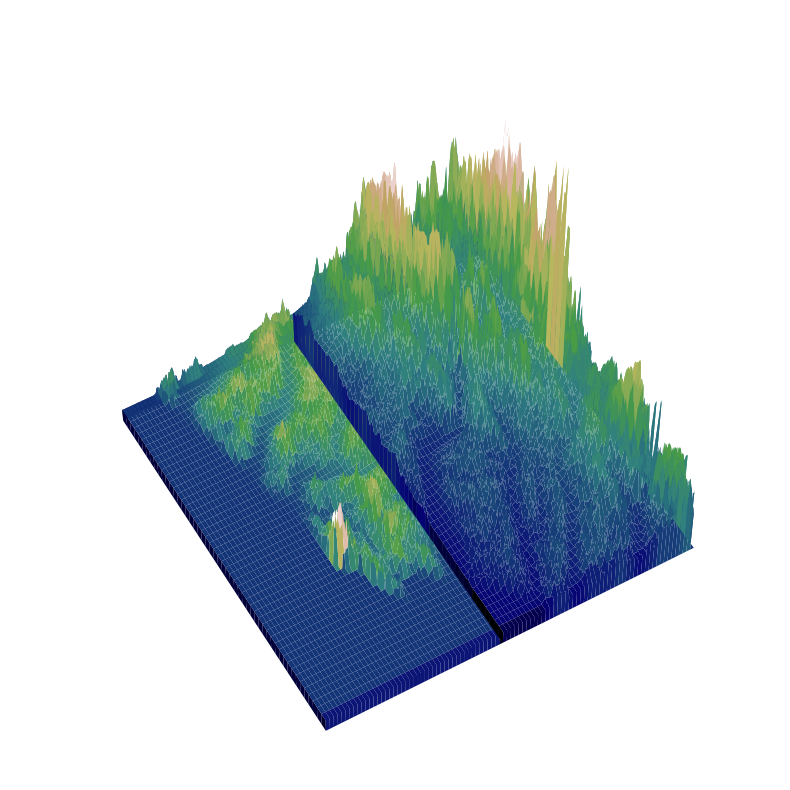

In [12]:
fig = plt.figure(1, figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(x1, y1, z1, rstride=100, cstride=100, edgecolor='none', cmap='gist_earth', lw=1)
ax.plot_surface(x2, y2, z2, rstride=100, cstride=100, edgecolor='none', cmap='gist_earth', lw=1)
ax.view_init(elev=55, azim=60) # ground level -> elevation=0, from above -> elevation=90
plt.axis('off')

In [13]:
x = np.arange(-5, 5, 1)
y = np.arange(-5, 5, 1)
xx, yy = np.meshgrid(x, y)
z = np.sin(xx**2 + yy**2) / (xx**2 + yy**2)

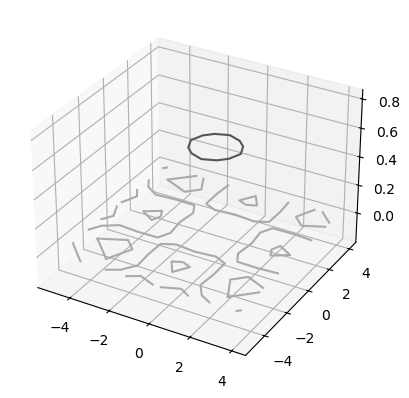

In [14]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(x, y, z, 1, cmap='binary')

## Opentopography DEM

(5010, 5010)


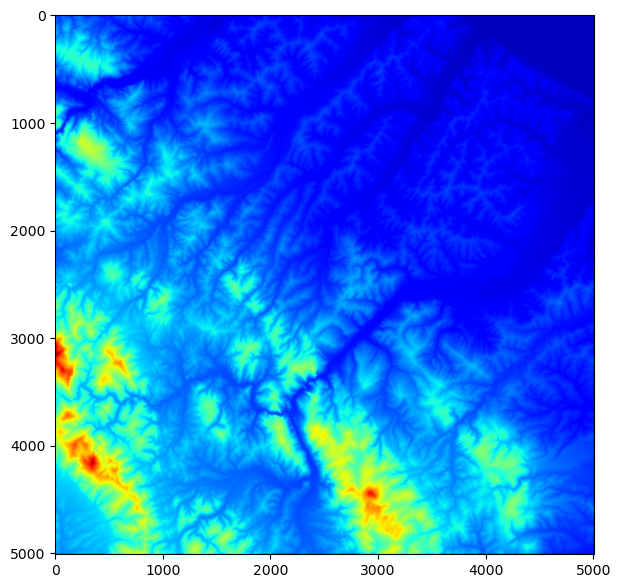

In [15]:
path = 'data/raster/italy/dem/opentopography/'
dem_path = path + 'output_COP30.tif'
img = io.imread(dem2_path)
print(img1.shape)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
ax.imshow(img1, cmap='jet')

In [16]:
from scipy import exp, mgrid, signal, row_stack, column_stack, tile, misc
def gaussian_blur(in_array, size):

    # expand in_array to fit edge of kernel, by repeating edge values
    ny, nx = in_array.shape
    ary = row_stack((tile(in_array[0,:], size).reshape((size, nx)),
                     in_array,
                     tile(in_array[-1,:], size).reshape((size, nx))))
    arx = column_stack((tile(ary[:,0], size).reshape((size, ny + size*2)).T,
                        ary,
                        tile(ary[:,-1], size).reshape((size, ny + size*2)).T))
    
    # build kernel
    x, y = mgrid[-size:size+1, -size:size+1]
    g = exp(-(2*x**2/float(size) + 2*y**2/float(size)))
    g = (g / g.sum()) #.astype(in_array.dtype)
    
    # do the gaussian blur over arx
    return signal.convolve(arx, g, mode='valid')

In [17]:
ds = gdal.Open(dem2_path, gdal.GA_ReadOnly)
band = ds.GetRasterBand(1)
z_tmp = band.ReadAsArray()
z = gaussian_blur(z_tmp, 3)
print("Band Type={}".format(gdal.GetDataTypeName(band.DataType)))
band.XSize, band.YSize, band.DataType, ds.GetProjection()

Band Type=Int32


(4505,
 5010,
 5,
 'PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32632"]]')

In [18]:
import scipy as sp
import scipy.interpolate
from scipy.interpolate import griddata

ds = gdal.Open(dem_path, gdal.GA_ReadOnly)
band = ds.GetRasterBand(1)
z = band.ReadAsArray()
geotransform = ds.GetGeoTransform()
min_x = geotransform[0]
max_y = geotransform[3]
max_x = min_x + band.XSize * geotransform[1]
min_y = max_y + band.YSize * geotransform[5]

x = np.arange(min_x, max_x, geotransform[1]) # grid x direction
y = np.arange(max_y, min_y, geotransform[5]) # grid y direction

X, Y = np.meshgrid(x[:band.XSize], y[:band.YSize])
#Z = griddata(X, Y, z, (x, y))

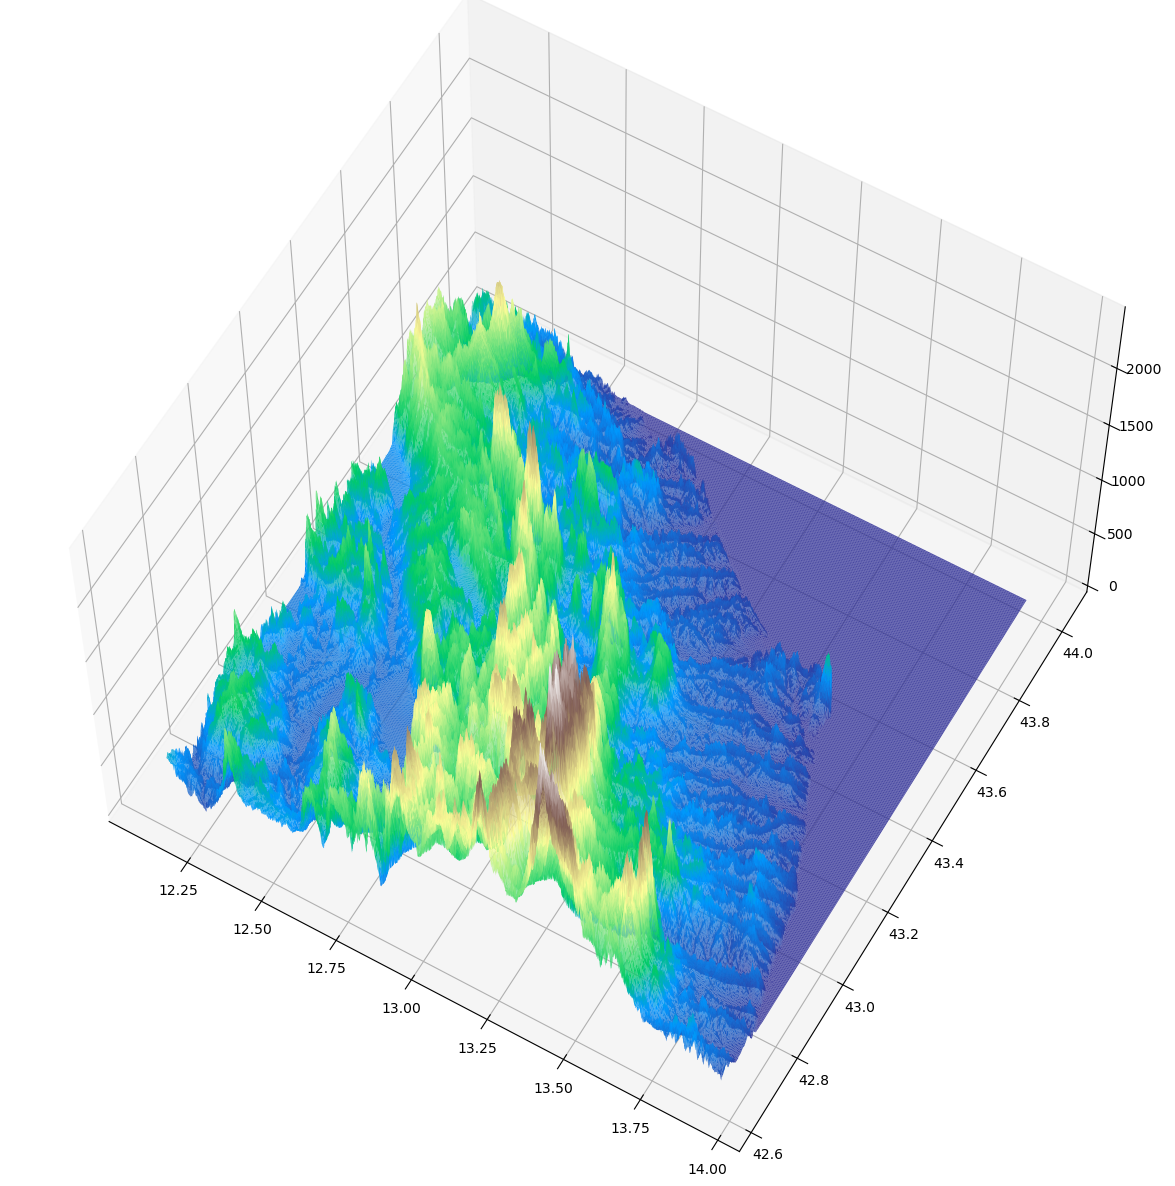

In [19]:
fig = plt.figure(1, figsize=(15, 15))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, z, rstride=10, cstride=10, edgecolor='none', cmap='terrain', lw=-100)
ax.view_init(elev=60, azim=-60) # ground level -> elevation=0, from above -> elevation=90
#plt.axis('off')

In [20]:
path = 'data/raster/italy/dem/opentopography/'
dem_path = path + 'output_COP30.tif'
ds = gdal.Open(dem2_path)
band = ds.GetRasterBand(1)
data = band.ReadAsArray()

In [21]:
geotransform = ds.GetGeoTransform()
minx = geotransform[0]
maxy = geotransform[3]
maxx = minx + band.XSize * geotransform[1]
miny = maxy + band.YSize * geotransform[5]
x = np.arange(minx, maxx, geotransform[1])
y = np.arange(maxy, miny, geotransform[5])
x, y = np.meshgrid(x[:band.XSize], y[:band.YSize])

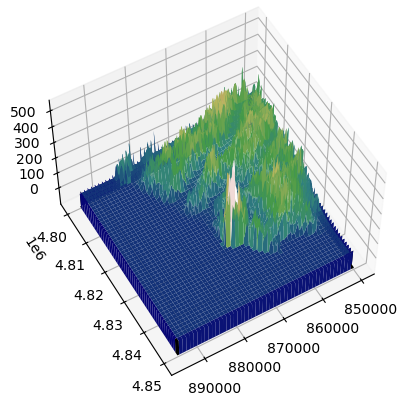

In [22]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, data, cmap='gist_earth', lw=0)
ax.view_init(elev=55, azim=60) # ground level -> elevation=0, from above -> elevation=90
#plt.axis('off')

## References
* [EU-DEM](https://land.copernicus.eu/imagery-in-situ/eu-dem)

# Credits
1. [Guth et al.- Digital Elevation Models: Terminology and Definitions](https://www.mdpi.com/2072-4292/13/18/3581)
2. Tarquini S., Isola I., Favalli M., Battistini A. (2007) TINITALY, a digital elevation model of Italy with a 10 m-cell size (Version 1.0) [Data set]. Istituto Nazionale di Geofisica e Vulcanologia (INGV). https://doi.org/10.13127/TINITALY/1.0.”